# RNN Model for Dopamine Level Prediction

This notebook implements an LSTM neural network to predict dopamine levels based on red PWM and blue PWM inputs using PyTorch.


## Step 1: Import Necessary Libraries


In [170]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import h5py
import os
import tqdm


In [171]:
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [172]:
from scipy import ndimage

def moving_zscore(data, window_size):
    moving_mean = ndimage.uniform_filter1d(data, size=window_size, mode='constant')
    moving_var = ndimage.uniform_filter1d(data**2, size=window_size, mode='constant') - moving_mean**2
    moving_std = np.sqrt(np.maximum(moving_var, 1e-8))
    return (data - moving_mean) / moving_std

## Step 2: Load and Prepare Your Data

For demonstration, we use sample data. In your case, you would load your three channels here.


In [190]:
session_name = '20251014-W-BiPOLES-DAT-2-Clamp_g0'
root_dir = '/Volumes/MICROSCOPE/Shun/Project clamping/Recordings/202509-BiPOLES/'
data_file_path = os.path.join(root_dir, f'{session_name}', f'data_{session_name}.mat')

# Load the MATLAB file
import mat73
data_mat = mat73.loadmat(data_file_path)

# Extract the data from the matlab file
red_laser_raw = data_mat['redClamp'].flatten()
blue_laser_raw = data_mat['blueClamp'].flatten()
dopamine_raw = data_mat['photometry_raw'].flatten()

ERROR:root:ERROR: MATLAB type not supported: string, (uint32)


In [185]:
# Preprocess the data
# Apply a low-pass Butterworth filter to the dopamine signal with 200 Hz cutoff
Fs = 10000  # Sampling frequency in Hz
cutoff = 200  # Cutoff frequency in Hz
dopamine_filtered = butter_lowpass_filter(dopamine_raw.flatten(), cutoff, Fs)

# Downsample to 200 Hz
targetFs = 10000
downsample_factor = int(Fs/targetFs)
red_laser = red_laser_raw[::downsample_factor]
blue_laser = blue_laser_raw[::downsample_factor]
dopamine = dopamine_filtered[::downsample_factor]
print(red_laser.shape)
print(blue_laser.shape)
print(dopamine.shape)

# Threshold laser signals
red_laser = (red_laser > 0.5).astype(int)
blue_laser = (blue_laser > 0.5).astype(int)

# Moving z-score of dopamine
window_size_sec = 180
window_size = int(window_size_sec * targetFs)
dopamine_zscore = np.zeros_like(dopamine)
print('Calculating z-score...')
dopamine_zscore = moving_zscore(dopamine, window_size)


# Create a DataFrame with the data
data = pd.DataFrame({
    'red_laser': red_laser,
    'blue_laser': blue_laser,
    'dopamine': dopamine_zscore
})

# Scale the dopamine signal
scaler = MinMaxScaler(feature_range=(0, 1))
data['dopamine_scaled'] = scaler.fit_transform(data[['dopamine']])

scaled_data = data[['red_laser', 'blue_laser', 'dopamine_scaled']].to_numpy()
print(scaled_data.shape)

(19525747,)
(19525747,)
(19525747,)
Calculating z-score...
(19525747, 3)


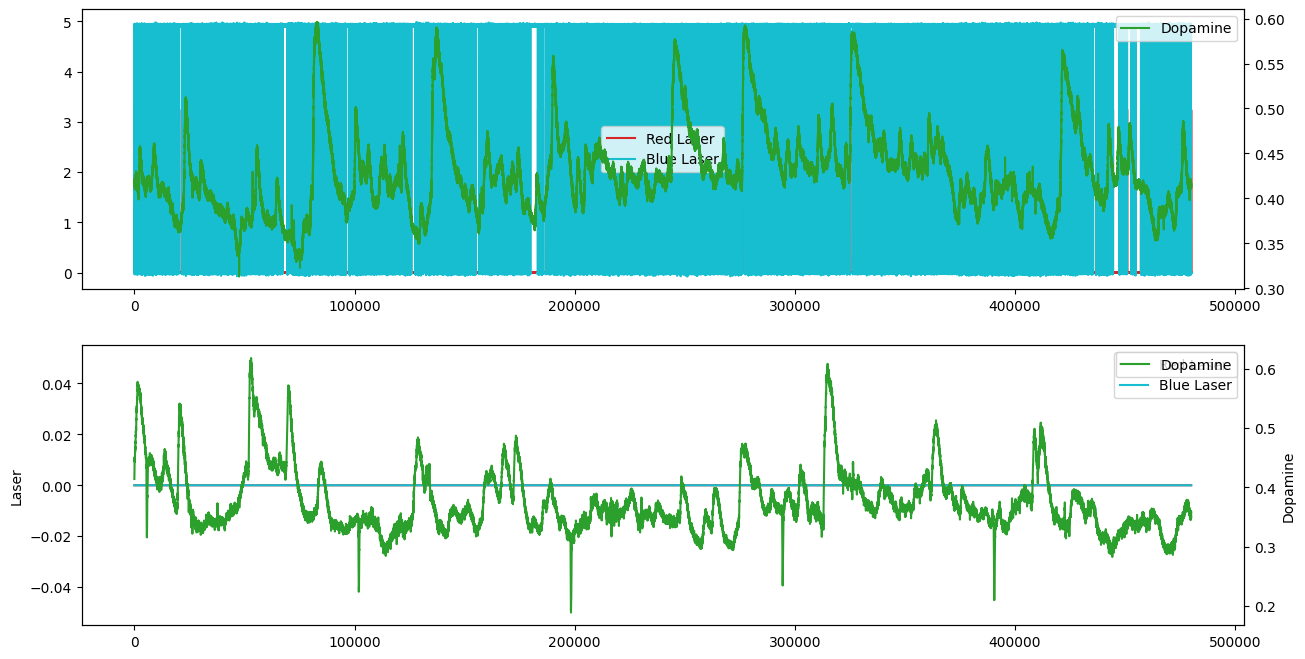

In [191]:
# Plot some data
# data_window_sec = (153.5,154) # 120-180 seconds
data_window_sec = (132,180) # 120-180 seconds
fig, axs = plt.subplots(2,1,figsize=(15, 8))

# Raw data
data_window = slice(int(data_window_sec[0]*Fs),int(data_window_sec[1]*Fs))
# Plot in left axis
axs[0].plot(red_laser_raw[data_window], label='Red Laser', color='tab:red')
axs[0].plot(blue_laser_raw[data_window], label='Blue Laser', color='tab:cyan')
# Plot in right axis
right_ax = axs[0].twinx()
right_ax.plot(dopamine_raw[data_window], label='Dopamine', color='tab:green')
axs[0].legend()
right_ax.legend()

# Downsampled & filtered
# data_window_sec = (153.6,153.7) # 120-180 seconds
data_window = slice(int(data_window_sec[0]*targetFs),int(data_window_sec[1]*targetFs))
# Plot in left axis
axs[1].plot(scaled_data[data_window,0], label='Red Laser', color='tab:red')
axs[1].plot(scaled_data[data_window,1], label='Blue Laser', color='tab:cyan')
axs[1].set_ylabel('Laser')
# Plot in right axis
right_ax = axs[1].twinx()
right_ax.plot(scaled_data[data_window,2], label='Dopamine', color='tab:green')
right_ax.set_ylabel('Dopamine')
axs[1].legend()
right_ax.legend()
plt.show()

## Step 3: Create dataset


In [ ]:
# Event-aligned dataset creation to prevent kernel crashes
def detect_pulse_events(red_laser, blue_laser, threshold=0.5, min_interval=1000):
    """
    Detect the first red and blue pulse events in the data.
    """
    
    red_pulses = np.where(np.diff(red_laser) > threshold)[0]
    red_events = red_pulses[np.where(np.diff(red_pulses) > min_interval)[0]]

    blue_pulses = np.where(np.diff(blue_laser) > threshold)[0]
    blue_events = blue_pulses[np.where(np.diff(blue_pulses) > min_interval)[0]]

    print(f"Detected {len(red_events)} red pulse events")
    print(f"Detected {len(blue_events)} blue pulse events")
    
    return red_events, blue_events


def create_event_aligned_dataset(dataset, look_back_sec=0.5, prediction_sec=0.5,
                                window_sec=10, fs=10000, threshold=0.1, step_size_ms=5):
    """
    Creates sequences of data aligned around pulse events.
    This prevents kernel crashes by using smaller, focused datasets.
    """
    
    # Detect pulse events
    red_laser = dataset[:,0]
    blue_laser = dataset[:,1]
    red_events, blue_events = detect_pulse_events(red_laser, blue_laser, threshold)
    
    if len(red_events) == 0 and len(blue_events) == 0:
        print("No pulse events detected. Using first portion of data instead.")
        # Fallback: use first portion of data
        max_samples = min(300*fs, len(dataset))  # Use max 5000 samples
        dataset = dataset[:max_samples]
        red_events = [1000]  # Placeholder event
        blue_events = []
    
    # Calculate window size in samples
    window_samples = int(window_sec * fs)
    half_window = window_samples // 2
    look_back = int(look_back_sec * fs)
    
    X, Y = [], []
    event_info = []
    
    # Process red pulse events
    for i, event_idx in enumerate(red_events):
        start_idx = max(0, event_idx - half_window)
        end_idx = min(len(dataset), event_idx + half_window)
        
        # Extract window around the event
        event_data = dataset[start_idx:end_idx]
        
        if len(event_data) >= look_back + 1:
            # Create sequences within this window (limit to prevent crashes)
            max_seqs_per_event = min(100, len(event_data) - look_back)
            for j in range(0, max_seqs_per_event, int(step_size_ms/1000*fs)):  # Take every 5th sequence
                seq_start = j
                seq_end = j + look_back
                pred_end = j + look_back + int(prediction_sec*fs)
                
                X.append(event_data[seq_start:seq_end])
                Y.append(event_data[seq_end:pred_end, :])  # last column is dopamine
                
                event_info.append({
                    'event_type': 'red',
                    'event_idx': event_idx,
                    'window_start': start_idx,
                    'window_end': end_idx,
                    'seq_idx': j
                })
    
    # Process blue pulse events
    for i, event_idx in enumerate(blue_events):
        start_idx = max(0, event_idx - half_window)
        end_idx = min(len(dataset), event_idx + half_window)
        
        # Extract window around the event
        event_data = dataset[start_idx:end_idx]
        
        if len(event_data) >= look_back + 1:
            # Create sequences within this window (limit to prevent crashes)
            max_seqs_per_event = min(100, len(event_data) - look_back)
            for j in range(0, max_seqs_per_event, int(step_size_ms/1000*fs)):  # Take every 5th sequence
                seq_start = j
                seq_end = j + look_back
                pred_end = j + look_back + int(prediction_sec*fs)
                
                X.append(event_data[seq_start:seq_end])
                Y.append(event_data[seq_end:pred_end, :])  # last column is dopamine
                
                event_info.append({
                    'event_type': 'blue',
                    'event_idx': event_idx,
                    'window_start': start_idx,
                    'window_end': end_idx,
                    'seq_idx': j
                })
    
    print(f"Created {len(X)} sequences from {len(red_events) + len(blue_events)} events")
    
    # Convert to PyTorch tensors
    if len(X) > 0:
        X = torch.tensor(np.array(X), dtype=torch.float32)
        Y = torch.tensor(np.array(Y), dtype=torch.float32)
        print(f"Dataset shapes: X={X.shape}, Y={Y.shape}")
    else:
        print("Warning: No sequences created. Creating fallback dataset.")
        # Fallback: create a small dataset from the beginning
        fallback_size = min(1000, len(dataset) - look_back)
        X_fallback = []
        Y_fallback = []
        for i in range(0, fallback_size, 10):  # Take every 10th sample
            seq_end = i + look_back
            pred_end = i + look_back + int(prediction_sec*fs)
            X_fallback.append(dataset[i:seq_end])
            Y_fallback.append(dataset[seq_end:pred_end, :])
        
        X = torch.tensor(np.array(X_fallback), dtype=torch.float32)
        Y = torch.tensor(np.array(Y_fallback), dtype=torch.float32)
        print(f"Fallback dataset shapes: X={X.shape}, Y={Y.shape}")
    
    return X, Y, event_info


Creating event-aligned dataset...
Detected 177 red pulse events
Detected 195 blue pulse events
Created 372 sequences from 372 events
Dataset shapes: X=torch.Size([372, 2000, 3]), Y=torch.Size([372, 1000, 3])
Final dataset shapes:
X shape: torch.Size([372, 2000, 3])
y shape: torch.Size([372, 1000, 3])
Memory usage: X=8.51 MB


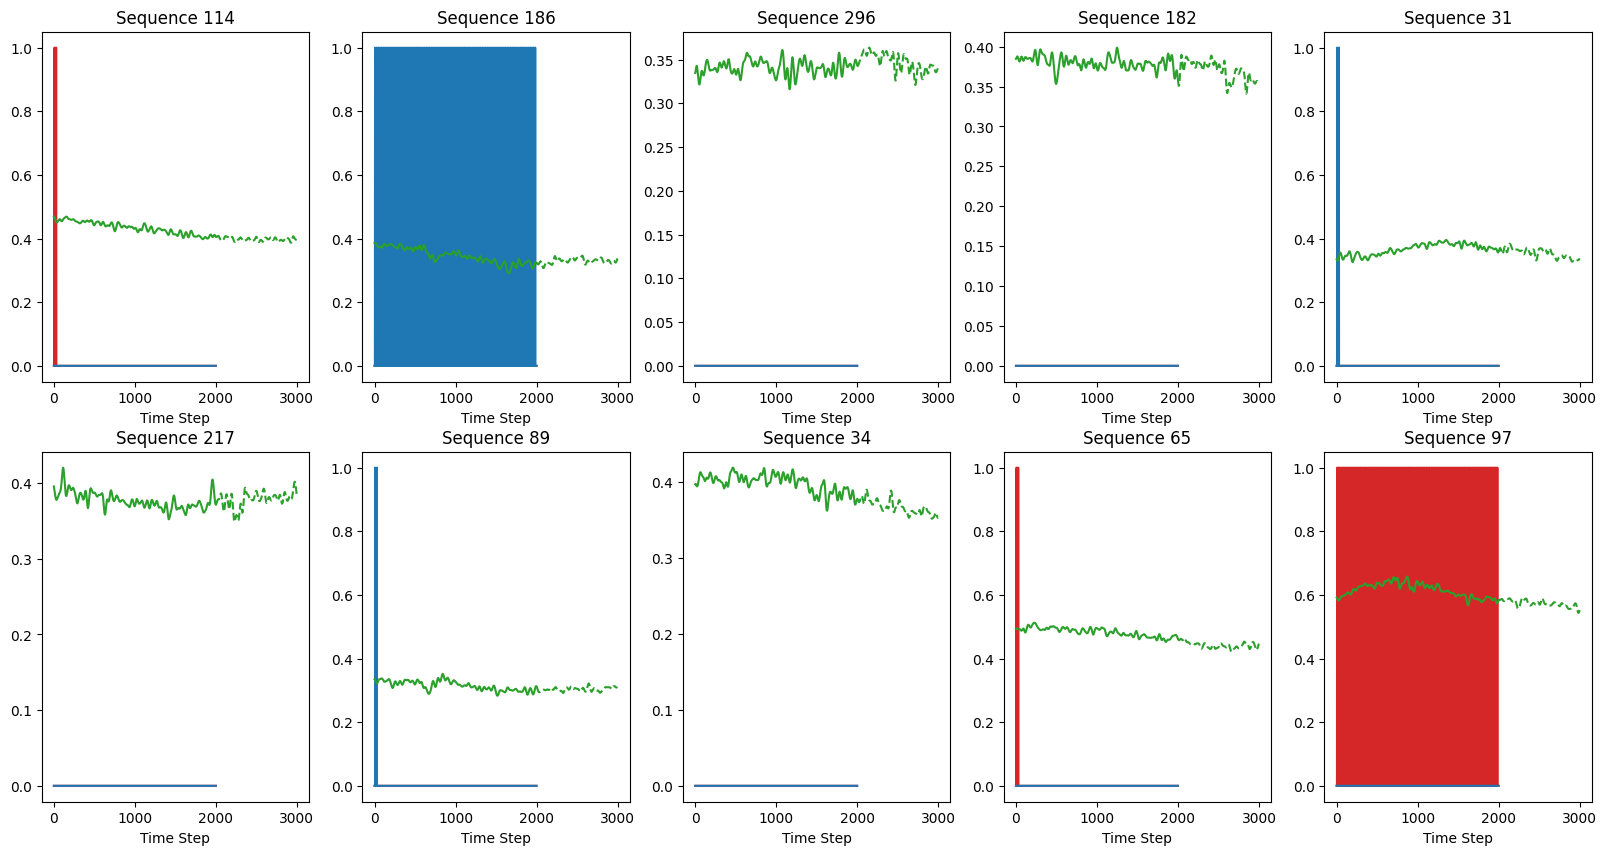

In [192]:
# Create event-aligned dataset (much smaller to prevent crashes)
look_back_sec, prediction_sec = 0.2, 0.1

print("Creating event-aligned dataset...")
X, y, event_info = create_event_aligned_dataset(
    scaled_data,
    window_sec=10,
    look_back_sec=look_back_sec,
    prediction_sec=prediction_sec,
    fs=targetFs,
    step_size_ms=10
)

print(f"Final dataset shapes:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Memory usage: X={X.numel() * 4 / 1024 / 1024:.2f} MB")

# Plot random 10 sequences with pulse events
pred_time = np.arange(X.shape[1],X.shape[1]+y.shape[1])
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    random_idx = np.random.randint(0, X.shape[0])
    plt.plot(X[random_idx,:,0], color='tab:red')
    plt.plot(X[random_idx,:,1], color='tab:blue')
    plt.plot(X[random_idx,:,2], color='tab:green')
    plt.plot(pred_time, y[random_idx,:,2], color='tab:green', linestyle='--')
    plt.title(f'Sequence {random_idx}')
    plt.xlabel('Time Step')
plt.show()

In [193]:
# Save dataset to folder
dataset_dir = '/Users/shunli/Projects/BrainClamp/data/TCN-dataset/'
save_dir = os.path.join(dataset_dir, f'dataset-{int(look_back_sec*1000)}ms-{int(prediction_sec*1000)}ms')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

np.savez(os.path.join(save_dir, f'dataset-{session_name}.npz'), X=X, y=y)
print(f"Dataset saved to {save_dir}")

Dataset saved to /Users/shunli/Projects/BrainClamp/data/TCN-dataset/dataset-200ms-100ms


## Step 4: Split into Training and Testing Sets


In [ ]:
# (Optional) Load directly from saved data

# save_dir = "/n/holylabs/LABS/bsabatini_lab/Users/shunnnli/BrainClamp/Data/20250918-W-BiPOLES-DAT-2_g0/dataset"
# file_name = "dataset-200ms-200ms.npz"

# # Load the dataset
# data = np.load(os.path.join(save_dir, file_name))
# X = data['X']
# y = data['y']


In [23]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print("\nData Splitting:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



Data Splitting:
X_train shape: torch.Size([303, 1000, 3])
y_train shape: torch.Size([303, 1000, 3])
X_test shape: torch.Size([76, 1000, 3])
y_test shape: torch.Size([76, 1000, 3])


## Step 5: setup TCN

In [ ]:
class Chomp1d(nn.Module):
    """Remove future information by chopping off the right padding"""
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """Temporal Convolutional Block with causal padding and residual connection"""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TCNModel(nn.Module):
    """Temporal Convolutional Network for time series prediction"""
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        # Calculate the receptive field
        receptive_field = 1
        for i in range(num_layers):
            receptive_field += (kernel_size - 1) * (2 ** i)
        self.receptive_field = receptive_field
        
        # Input projection layer
        # self.input_projection = nn.Linear(input_size, hidden_size)
        self.input_projection = nn.Conv1d(input_size, hidden_size, kernel_size=1) if input_size != hidden_size else None
        
        # Temporal blocks
        layers = []
        num_channels = [hidden_size] * num_layers
        
        for i in range(num_layers):
            dilation_size = 2 ** i
            in_channels = hidden_size if i == 0 else hidden_size
            out_channels = num_channels[i]
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()
        
        # Transpose for TCN: (batch_size, seq_len, input_size) -> (batch_size, input_size, seq_len)
        x = x.transpose(1, 2)
        
        # Input projection
        if self.input_projection is not None:
            x = self.input_projection(x)
        
        # TCN processing
        x = self.network(x)  # (batch_size, hidden_size, seq_len)
        
        # Transpose back for output layer
        x = x.transpose(1, 2)  # (batch_size, seq_len, hidden_size)
        
        # Apply output layer to each timestep
        out = self.output_layer(x)  # (batch_size, seq_len, output_size)
        
        return out

    def weighted_loss(self, pred, target, gamma=0.999):
        dopamine = target[:, :, -1].unsqueeze(-1)
        laser_mask = torch.logical_or(target[:, :, 0] > 0.5, target[:, :, 1] > 0.5)
        seq_len = pred.shape[1] if pred.dim() > 1 else pred.shape[0]
        time_points = torch.arange(seq_len, device=pred.device)

        base_loss = nn.MSELoss()(pred, dopamine)
        proximity_weight = gamma ** time_points  # 1 for t=0, gamma for t=1, gamma^2 for t=2, ...
        laser_weight = 2.0 * laser_mask.unsqueeze(-1) # double the weight of laser events

        weighted_loss = base_loss * proximity_weight * laser_weight
        return weighted_loss.mean()




In [ ]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
        
#         # Define the LSTM layer
#         # `batch_first=True` means the input tensor shape is (batch, seq, feature)
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
#         # Define the output layer
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # Initialize hidden and cell states
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
#         # Forward propagate LSTM
#         # out: tensor of shape (batch_size, seq_length, hidden_size)
#         out, _ = self.lstm(x, (h0, c0))
        
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out

## Step 6: Build the Model in PyTorch


In [8]:
# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Model parameters
input_size = X_train.shape[2]  # Number of features (3)
hidden_size = 128
num_layers = 8 
output_size = 1

# Create TCN model
tcn_model = TCNModel(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers,
    output_size=output_size, 
    kernel_size=3,  # TCN kernel size
    dropout=0.2
)

print("\nTCN Model Architecture:")
print(tcn_model)
print(f"\nTCN Receptive Field: {tcn_model.receptive_field}")
print(f"Input sequence length: {X_train.shape[1]}")
print(f"Hidden size: {hidden_size}")
print(f"Number of layers: {num_layers}")

# Use TCN model
model = tcn_model
model = model.to(device)


TCN Model Architecture:
TCNModel(
  (input_projection): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): Chomp1d()
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,))
        (5): Chomp1d()
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
      )
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
    

In [ ]:
# # Model parameters
# input_size = X_train.shape[2]  # Number of features (3)
# hidden_size = 50
# num_layers = 2 # Corresponds to two stacked LSTM layers
# output_size = 1

# model = LSTMModel(input_size, hidden_size, num_layers, output_size)
# print("\nModel Architecture:")
# print(model)

## Step 7: Train the Model


In [ ]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Create dataloader for batch training
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=(X_train, y_train), batch_size=32, shuffle=True)

print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Move data to the same device as the model
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_X)
        loss = model.weighted_loss(outputs, batch_y, gamma=0.999)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = model.weighted_loss(val_outputs, y_test, gamma=0.999)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {val_loss.item():.4f}')

print("Training complete.")



Starting model training...


KeyboardInterrupt: 

In [ ]:
# Check GPU memory before and after
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")

## Step 8: Evaluate and Visualize the Results


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
# Make predictions
model.eval() # Ensure model is in evaluation mode
with torch.no_grad():
    train_predict = model(X_train)
    test_predict = model(X_test)

# Convert tensors to numpy arrays for inverse scaling and plotting
train_predict_np = train_predict.numpy()
test_predict_np = test_predict.numpy()
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()

# To properly inverse transform, we need a dummy array with the same
# number of features as the original scaler.
def inverse_transform_predictions(predictions, scaler, n_features):
    dummy_array = np.zeros((len(predictions), n_features))
    dummy_array[:, 0] = predictions.ravel()
    inversed = scaler.inverse_transform(dummy_array)
    return inversed[:, 0]

train_predict_orig = inverse_transform_predictions(train_predict_np, scaler, input_size)
y_train_orig = inverse_transform_predictions(y_train_np, scaler, input_size)
test_predict_orig = inverse_transform_predictions(test_predict_np, scaler, input_size)
y_test_orig = inverse_transform_predictions(y_test_np, scaler, input_size)


In [ ]:
# Plot the results on the test set
fig, axs = plt.subplots(2,1,figsize=(15, 10))
axs[0].plot(y_test_orig, color='blue', label='Actual Dopamine Level')
axs[0].plot(test_predict_orig, color='red', linestyle='--', label='Predicted Dopamine Level')
axs[0].set_title('Dopamine Level Prediction on Test Data')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Dopamine Level')
axs[0].legend()

axs[1].plot(y_train_orig, color='blue', label='Actual Dopamine Level')
axs[1].plot(train_predict_orig, color='red', linestyle='--', label='Predicted Dopamine Level')
axs[1].set_title('Dopamine Level Prediction on Training Data')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Dopamine Level')
axs[1].legend()

plt.show()


In [ ]:
def simulate_input_data(red_laser, blue_laser, input_duration=0.5,
                        fs=10000, plot=False, stim_samples=500):
    simulate_samples = int(input_duration * fs)
    simulated_dopamine = np.random.randn(simulate_samples)
    simulated_red_laser = np.zeros(simulate_samples)
    simulated_blue_laser = np.zeros(simulate_samples)

    # Make red laser pulses (5 samples per pulse) in the last 100ms
    if red_laser:
        red_laser_start = simulate_samples - stim_samples
        for i in range(red_laser_start, simulate_samples,15):
            simulated_red_laser[i:i+5] = 1
        # add small ramp up of dopamine signal
        simulated_dopamine[red_laser_start:simulate_samples] += np.linspace(0, 1, stim_samples)
            

    if blue_laser:
        blue_laser_start = simulate_samples - stim_samples
        for i in range(blue_laser_start, simulate_samples,15):
            simulated_blue_laser[i:i+5] = 1
        # add small ramp up of dopamine signal
        simulated_dopamine[blue_laser_start:simulate_samples] -= np.linspace(0, 1, stim_samples)

    # low pass filter the dopamine signal
    cutoff = 200  # Cutoff frequency in Hz
    simulated_dopamine = butter_lowpass_filter(simulated_dopamine.flatten(), cutoff, fs)

    if plot:
        plt.plot(simulated_dopamine, color='green')
        plt.plot(simulated_red_laser, color='red')
        plt.plot(simulated_blue_laser, color='blue')
        plt.show()

    return np.vstack((simulated_red_laser, simulated_blue_laser, simulated_dopamine)).T


In [ ]:
# Feed in an artificial 500ms data sequence and predict the output

# 1. Generate a random 500ms data sequence with no/red/blue laser pulse for last 100ms
fake_no_laser = simulate_input_data(red_laser=False, blue_laser=False, input_duration=0.5, fs=10000, plot=False)
fake_no_laser_scaled = scaler.transform(fake_no_laser)
fake_no_laser_tensor = torch.from_numpy(fake_no_laser).float().unsqueeze(0)
fake_red_laser = simulate_input_data(red_laser=True, blue_laser=False, input_duration=0.5, fs=10000, plot=False)
fake_red_laser_scaled = scaler.transform(fake_red_laser)
fake_red_laser_tensor = torch.from_numpy(fake_red_laser).float().unsqueeze(0)
fake_blue_laser = simulate_input_data(red_laser=False, blue_laser=True, input_duration=0.5, fs=10000, plot=False)
fake_blue_laser_scaled = scaler.transform(fake_blue_laser)
fake_blue_laser_tensor = torch.from_numpy(fake_blue_laser).float().unsqueeze(0)


# 2. Predict the output for the future 500ms 
n_pred_samples = int(0.1 * targetFs)
pred_no_laser = torch.zeros((n_pred_samples, 1))
pred_red_laser = torch.zeros((n_pred_samples, 1))
pred_blue_laser = torch.zeros((n_pred_samples, 1))

model.eval()
with torch.no_grad():
    for i in tqdm.tqdm(range(n_pred_samples)):
        # Predict the output
        no_laser_pred = model(fake_no_laser_tensor).numpy()
        red_laser_pred = model(fake_red_laser_tensor).numpy()
        blue_laser_pred = model(fake_blue_laser_tensor).numpy()

        # Inverse transform the predictions
        dopamine_min = scaler.min_[2]  # Third feature (dopamine)
        dopamine_scale = scaler.scale_[2]  # Third feature (dopamine)
        no_laser_pred_orig = no_laser_pred * dopamine_scale + dopamine_min
        red_laser_pred_orig = red_laser_pred * dopamine_scale + dopamine_min
        blue_laser_pred_orig = blue_laser_pred * dopamine_scale + dopamine_min

        # Store the predictions
        pred_no_laser[i] = torch.from_numpy(no_laser_pred_orig)
        pred_red_laser[i] = torch.from_numpy(red_laser_pred_orig)
        pred_blue_laser[i] = torch.from_numpy(blue_laser_pred_orig)

        # shift the time step by 1 and add the new dopamine level
        new_sample = [0, 0, pred_no_laser[i].item()]  # Use .item() to get scalar value
        new_sample_tensor = torch.tensor(new_sample).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3)
        fake_no_laser_tensor = torch.cat((fake_no_laser_tensor[:, 1:, :], new_sample_tensor), dim=1)
        fake_red_laser_tensor = torch.cat((fake_red_laser_tensor[:, 1:, :], new_sample_tensor), dim=1)
        fake_blue_laser_tensor = torch.cat((fake_blue_laser_tensor[:, 1:, :], new_sample_tensor), dim=1)



In [ ]:
# Plot fake_no_laser_tensor
fig, axs = plt.subplots(3,1,figsize=(15, 7))
axs[0].plot(fake_no_laser_tensor[:,:,2].squeeze().numpy(), color='green')
axs[1].plot(fake_red_laser_tensor[:,:,0].squeeze().numpy(), color='green')
axs[2].plot(fake_blue_laser_tensor[:,:,1].squeeze().numpy(), color='green')


In [ ]:
# 3. Plot the results
fig, axs = plt.subplots(3,2,figsize=(15, 7))
axs[0,0].plot(fake_no_laser[:,0], color='red')
axs[0,0].plot(fake_no_laser[:,1], color='blue')
axs[0,0].plot(fake_no_laser[:,2], color='green')

axs[1,0].plot(fake_red_laser[:,0], color='red')
axs[1,0].plot(fake_red_laser[:,1], color='blue')
axs[1,0].plot(fake_red_laser[:,2], color='green')

axs[2,0].plot(fake_blue_laser[:,0], color='red')
axs[2,0].plot(fake_blue_laser[:,1], color='blue')
axs[2,0].plot(fake_blue_laser[:,2], color='green')

axs[0,1].plot(pred_no_laser, color='gray')
axs[1,1].plot(pred_red_laser, color='red')
axs[2,1].plot(pred_blue_laser, color='blue')

## Step 9: Save the model

In [ ]:
# Save the model
import os
from datetime import datetime

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Get today's date as YYYY-MM-DD
today_str = datetime.today().strftime('%Y%m%d')
model_filename = f"models/TCN-{today_str}.pt"

# Save the PyTorch model's state_dict
torch.save(model.state_dict(), model_filename)

print(f"Model saved to {model_filename}")


In [ ]:
# Load the model
model_filename = "models/TCN-20251010.pt"

# Model parameters
input_size = X_train.shape[2]  # Number of features (3)
hidden_size = 128
num_layers = 8 
output_size = 1

# Create TCN model
model = TCNModel(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers,
    output_size=output_size, 
    kernel_size=3,  # TCN kernel size
    dropout=0.2
)

model.load_state_dict(torch.load(model_filename))

## Setup a PID controller with RL gain control

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random

class PIDController:
    """PID Controller with RL-based gain adaptation"""
    
    def __init__(self, target_dopamine=0.5, kp_init=1.0, ki_init=0.1, kd_init=0.01):
        # Target dopamine level
        self.target_dopamine = target_dopamine
        
        # Initial PID gains
        self.kp = kp_init
        self.ki = ki_init
        self.kd = kd_init
        
        # PID state variables
        self.previous_error = 0.0
        self.integral = 0.0
        
        # Control output limits
        self.output_min = -1.0
        self.output_max = 1.0
        
        # History for analysis
        self.error_history = []
        self.output_history = []
        self.gain_history = {'kp': [], 'ki': [], 'kd': []}
        
    def update(self, current_dopamine, dt=1.0):
        """Update PID controller with current dopamine reading"""
        # Calculate error
        error = self.target_dopamine - current_dopamine
        
        # Proportional term
        proportional = self.kp * error
        
        # Integral term
        self.integral += error * dt
        integral_term = self.ki * self.integral
        
        # Derivative term
        derivative = (error - self.previous_error) / dt
        derivative_term = self.kd * derivative
        
        # Calculate PID output
        output = proportional + integral_term + derivative_term
        
        # Apply output limits
        output = np.clip(output, self.output_min, self.output_max)
        
        # Update previous error
        self.previous_error = error
        
        # Store history
        self.error_history.append(error)
        self.output_history.append(output)
        self.gain_history['kp'].append(self.kp)
        self.gain_history['ki'].append(self.ki)
        self.gain_history['kd'].append(self.kd)
        
        return output
    
    def update_gains(self, delta_kp, delta_ki, delta_kd):
        """Update PID gains with constraints"""
        # Update gains with learning rates
        lr_p = 0.01
        lr_i = 0.005
        lr_d = 0.001
        
        self.kp += lr_p * delta_kp
        self.ki += lr_i * delta_ki
        self.kd += lr_d * delta_kd
        
        # Apply constraints to keep gains positive and reasonable
        self.kp = np.clip(self.kp, 0.1, 10.0)
        self.ki = np.clip(self.ki, 0.0, 2.0)
        self.kd = np.clip(self.kd, 0.0, 1.0)
    
    def reset(self):
        """Reset PID controller state"""
        self.previous_error = 0.0
        self.integral = 0.0
        self.error_history = []
        self.output_history = []
        self.gain_history = {'kp': [], 'ki': [], 'kd': []}


class RLGainOptimizer:
    """Reinforcement Learning optimizer for PID gains"""
    
    def __init__(self, state_dim=4, action_dim=3, learning_rate=0.001):
        self.state_dim = state_dim  # [error, error_history, integral, derivative]
        self.action_dim = action_dim  # [delta_kp, delta_ki, delta_kd]
        
        # Neural network for policy
        self.policy_net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Tanh()  # Output between -1 and 1
        )
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Experience replay buffer
        self.memory = deque(maxlen=10000)
        self.batch_size = 32
        
        # Hyperparameters
        self.gamma = 0.99  # Discount factor
        self.epsilon = 0.1  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
    def get_state(self, pid_controller):
        """Extract state from PID controller"""
        if len(pid_controller.error_history) < 2:
            return np.zeros(self.state_dim)
        
        # Current error
        current_error = pid_controller.error_history[-1]
        
        # Error trend (average of last 5 errors)
        error_trend = np.mean(pid_controller.error_history[-5:]) if len(pid_controller.error_history) >= 5 else current_error
        
        # Integral value
        integral = pid_controller.integral
        
        # Derivative (approximate)
        derivative = 0.0
        if len(pid_controller.error_history) >= 2:
            derivative = pid_controller.error_history[-1] - pid_controller.error_history[-2]
        
        return np.array([current_error, error_trend, integral, derivative])
    
    def select_action(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.random() < self.epsilon:
            # Random action for exploration
            return np.random.uniform(-1, 1, self.action_dim)
        else:
            # Greedy action from policy network
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action = self.policy_net(state_tensor).squeeze().numpy()
            return action
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self):
        """Train the policy network using experience replay"""
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from memory
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.FloatTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        
        # Compute current Q values
        current_q_values = self.policy_net(states)
        
        # Compute target Q values (simplified - using immediate reward)
        target_q_values = rewards.unsqueeze(1).expand_as(current_q_values)
        
        # Compute loss (MSE between current and target Q values)
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def simulate_dopamine_clamping_with_rl_pid(num_steps=1000, target_dopamine=0.5):
    """Simulate dopamine clamping with RL-optimized PID controller"""
    
    # Initialize PID controller and RL optimizer
    pid = PIDController(target_dopamine=target_dopamine)
    rl_optimizer = RLGainOptimizer()
    
    # Simulation parameters
    dt = 0.1
    current_dopamine = 0.3  # Initial dopamine level
    
    # System dynamics (simplified dopamine dynamics)
    dopamine_dynamics = {
        'baseline': 0.3,
        'time_constant': 2.0,
        'noise_std': 0.05
    }
    
    # Storage for results
    results = {
        'time': [],
        'dopamine': [],
        'target': [],
        'control_output': [],
        'error': [],
        'kp': [],
        'ki': [],
        'kd': []
    }
    
    print("Starting dopamine clamping simulation with RL-PID...")
    
    for step in range(num_steps):
        current_time = step * dt
        
        # Get PID control output
        control_output = pid.update(current_dopamine, dt)
        
        # Simulate dopamine dynamics (simplified)
        # Dopamine responds to control input with some dynamics
        dopamine_change = (dopamine_dynamics['baseline'] + control_output * 0.5 - current_dopamine) / dopamine_dynamics['time_constant']
        current_dopamine += dopamine_change * dt
        
        # Add noise
        current_dopamine += np.random.normal(0, dopamine_dynamics['noise_std'])
        
        # Ensure dopamine stays in reasonable range
        current_dopamine = np.clip(current_dopamine, 0.0, 1.0)
        
        # Calculate reward (negative squared error)
        error = target_dopamine - current_dopamine
        reward = -(error ** 2)
        
        # Get current state
        current_state = rl_optimizer.get_state(pid)
        
        # Select action and update gains (every 10 steps)
        if step % 10 == 0 and step > 0:
            action = rl_optimizer.select_action(current_state)
            pid.update_gains(action[0], action[1], action[2])
            
            # Get next state
            next_state = rl_optimizer.get_state(pid)
            
            # Store experience
            rl_optimizer.remember(current_state, action, reward, next_state, False)
            
            # Train the RL agent
            rl_optimizer.replay()
        
        # Store results
        results['time'].append(current_time)
        results['dopamine'].append(current_dopamine)
        results['target'].append(target_dopamine)
        results['control_output'].append(control_output)
        results['error'].append(error)
        results['kp'].append(pid.kp)
        results['ki'].append(pid.ki)
        results['kd'].append(pid.kd)
        
        # Print progress
        if step % 100 == 0:
            print(f"Step {step}: Dopamine={current_dopamine:.3f}, Error={error:.3f}, "
                  f"Gains: Kp={pid.kp:.3f}, Ki={pid.ki:.3f}, Kd={pid.kd:.3f}")
    
    return results, pid, rl_optimizer


In [ ]:
# Run the RL-PID simulation
results, pid_controller, rl_optimizer = simulate_dopamine_clamping_with_rl_pid(
    num_steps=2000, 
    target_dopamine=0.6
)

print(f"\nSimulation completed!")
print(f"Final gains: Kp={pid_controller.kp:.3f}, Ki={pid_controller.ki:.3f}, Kd={pid_controller.kd:.3f}")

# Calculate performance metrics
final_error = np.mean(np.abs(results['error'][-100:]))  # Mean absolute error in last 100 steps
rmse = np.sqrt(np.mean(np.array(results['error'])**2))  # Root mean square error
print(f"Final MAE (last 100 steps): {final_error:.4f}")
print(f"Overall RMSE: {rmse:.4f}")


In [ ]:
# Visualize the RL-PID controller performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Dopamine level and target
axes[0, 0].plot(results['time'], results['dopamine'], label='Actual Dopamine', alpha=0.8)
axes[0, 0].plot(results['time'], results['target'], label='Target Dopamine', linestyle='--', color='red')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Dopamine Level')
axes[0, 0].set_title('Dopamine Clamping Performance')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Control output
axes[0, 1].plot(results['time'], results['control_output'], label='Control Output', color='green')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Control Output')
axes[0, 1].set_title('PID Control Output')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Error over time
axes[1, 0].plot(results['time'], results['error'], label='Control Error', color='orange')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Error (Target - Actual)')
axes[1, 0].set_title('Control Error Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: PID gains evolution
axes[1, 1].plot(results['time'], results['kp'], label='Kp (Proportional)', linewidth=2)
axes[1, 1].plot(results['time'], results['ki'], label='Ki (Integral)', linewidth=2)
axes[1, 1].plot(results['time'], results['kd'], label='Kd (Derivative)', linewidth=2)
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Gain Value')
axes[1, 1].set_title('RL-Optimized PID Gains Evolution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Integration with TCN Model for Real-time Dopamine Prediction and Control
def integrate_tcn_with_pid_controller(model, pid_controller, rl_optimizer, data_sequence, target_dopamine=0.6):
    """
    Integrate TCN model predictions with PID controller for real-time dopamine clamping
    """
    print("Running integrated TCN-PID dopamine clamping...")
    
    # Set model to evaluation mode
    model.eval()
    
    results = {
        'time': [],
        'predicted_dopamine': [],
        'actual_dopamine': [],
        'target': [],
        'control_output': [],
        'error': [],
        'kp': [],
        'ki': [],
        'kd': []
    }
    
    # Use the last part of the test data for simulation
    sequence_length = model.receptive_field
    start_idx = len(data_sequence) - 1000  # Use last 1000 points
    
    current_dopamine = data_sequence[start_idx, 0]  # Start with actual dopamine level
    
    for i in range(1000):  # Simulate 1000 steps
        current_idx = start_idx + i
        current_time = i * 0.1
        
        # Get input sequence for TCN model
        if current_idx >= sequence_length:
            input_seq = data_sequence[current_idx - sequence_length:current_idx, :]
            input_tensor = torch.FloatTensor(input_seq).unsqueeze(0)  # Add batch dimension
            
            # Get TCN prediction
            with torch.no_grad():
                predicted_dopamine = model(input_tensor).item()
        else:
            predicted_dopamine = current_dopamine
        
        # Use TCN prediction for PID control
        control_output = pid_controller.update(predicted_dopamine, dt=0.1)
        
        # Simulate actual dopamine response (with some dynamics)
        actual_dopamine = data_sequence[current_idx, 0] if current_idx < len(data_sequence) else current_dopamine
        
        # Add some realistic dynamics
        dopamine_change = (actual_dopamine + control_output * 0.3 - current_dopamine) / 1.5
        current_dopamine += dopamine_change * 0.1
        current_dopamine = np.clip(current_dopamine, 0.0, 1.0)
        
        # Calculate reward and update RL agent (every 10 steps)
        error = target_dopamine - current_dopamine
        reward = -(error ** 2)
        
        if i % 10 == 0 and i > 0:
            current_state = rl_optimizer.get_state(pid_controller)
            action = rl_optimizer.select_action(current_state)
            pid_controller.update_gains(action[0], action[1], action[2])
            
            next_state = rl_optimizer.get_state(pid_controller)
            rl_optimizer.remember(current_state, action, reward, next_state, False)
            rl_optimizer.replay()
        
        # Store results
        results['time'].append(current_time)
        results['predicted_dopamine'].append(predicted_dopamine)
        results['actual_dopamine'].append(current_dopamine)
        results['target'].append(target_dopamine)
        results['control_output'].append(control_output)
        results['error'].append(error)
        results['kp'].append(pid_controller.kp)
        results['ki'].append(pid_controller.ki)
        results['kd'].append(pid_controller.kd)
        
        if i % 100 == 0:
            print(f"Step {i}: Predicted={predicted_dopamine:.3f}, Actual={current_dopamine:.3f}, "
                  f"Error={error:.3f}, Gains: Kp={pid_controller.kp:.3f}, Ki={pid_controller.ki:.3f}, Kd={pid_controller.kd:.3f}")
    
    return results

# Run integrated TCN-PID simulation
print("\\n" + "="*60)
print("INTEGRATED TCN-PID DOPAMINE CLAMPING SIMULATION")
print("="*60)

# Reset PID controller for fresh start
pid_controller.reset()
rl_optimizer.epsilon = 0.1  # Reset exploration

# Run the integrated simulation
integrated_results = integrate_tcn_with_pid_controller(
    model, 
    pid_controller, 
    rl_optimizer, 
    scaled_data,  # Use the scaled data from earlier
    target_dopamine=0.6
)

print(f"\\nIntegrated simulation completed!")
print(f"Final gains: Kp={pid_controller.kp:.3f}, Ki={pid_controller.ki:.3f}, Kd={pid_controller.kd:.3f}")

# Calculate integrated performance metrics
final_error_integrated = np.mean(np.abs(integrated_results['error'][-100:]))
rmse_integrated = np.sqrt(np.mean(np.array(integrated_results['error'])**2))
print(f"Final MAE (last 100 steps): {final_error_integrated:.4f}")
print(f"Overall RMSE: {rmse_integrated:.4f}")


In [ ]:
# Visualize the integrated TCN-PID controller performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Predicted vs Actual dopamine with target
axes[0, 0].plot(integrated_results['time'], integrated_results['predicted_dopamine'], 
                label='TCN Predicted', alpha=0.7, color='blue')
axes[0, 0].plot(integrated_results['time'], integrated_results['actual_dopamine'], 
                label='Actual Dopamine', alpha=0.8, color='green')
axes[0, 0].plot(integrated_results['time'], integrated_results['target'], 
                label='Target', linestyle='--', color='red')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Dopamine Level')
axes[0, 0].set_title('TCN-PID Integrated Dopamine Clamping')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Control output
axes[0, 1].plot(integrated_results['time'], integrated_results['control_output'], 
                label='Control Output', color='purple')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Control Output')
axes[0, 1].set_title('PID Control Output (TCN-Integrated)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Prediction error vs control error
prediction_error = np.array(integrated_results['predicted_dopamine']) - np.array(integrated_results['actual_dopamine'])
axes[1, 0].plot(integrated_results['time'], prediction_error, 
                label='Prediction Error', color='orange', alpha=0.7)
axes[1, 0].plot(integrated_results['time'], integrated_results['error'], 
                label='Control Error', color='red', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Error')
axes[1, 0].set_title('Prediction Error vs Control Error')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: RL-optimized PID gains evolution
axes[1, 1].plot(integrated_results['time'], integrated_results['kp'], 
                label='Kp (Proportional)', linewidth=2)
axes[1, 1].plot(integrated_results['time'], integrated_results['ki'], 
                label='Ki (Integral)', linewidth=2)
axes[1, 1].plot(integrated_results['time'], integrated_results['kd'], 
                label='Kd (Derivative)', linewidth=2)
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Gain Value')
axes[1, 1].set_title('RL-Optimized PID Gains (TCN-Integrated)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"TCN Model Receptive Field: {model.receptive_field} timesteps")
print(f"Final PID Gains: Kp={pid_controller.kp:.3f}, Ki={pid_controller.ki:.3f}, Kd={pid_controller.kd:.3f}")
print(f"Final Control Error (MAE): {final_error_integrated:.4f}")
print(f"Overall Control Error (RMSE): {rmse_integrated:.4f}")
print(f"Average Prediction Error: {np.mean(np.abs(prediction_error)):.4f}")
print(f"Exploration Rate (final): {rl_optimizer.epsilon:.3f}")
print("="*60)


## Test
